In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats as stat
from tqdm import tqdm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
plt.rcParams["figure.figsize"] = (7, 7)

In [2]:
df = pd.read_csv('formatted_bike_data.csv', index_col=0)
df.head()

,duration,start_date,end_date,start_station_number,start_station,end_station_number,end_station,bike_number,member_type,day_of_week,days_since_jan1_2010,date,route,conditions_rain,conditions_snow,is_weekend,time_of_day_morning,time_of_day_night,time_of_day_noon,temp_regular
0,1012,2010-09-20 11:27:04,2010-09-20 11:43:56,31208,M St & New Jersey Ave SE,31108,4th & M St SW,W00742,1,Monday,262,2010-09-20,M St & New Jersey Ave SE4th & M St SW,0,0,0,0,0,1,1
1,2690,2010-09-20 12:05:37,2010-09-20 12:50:27,31600,5th & K St NW,31100,19th St & Pennsylvania Ave NW,W00993,1,Monday,262,2010-09-20,5th & K St NW19th St & Pennsylvania Ave NW,0,0,0,0,0,1,1
2,1413,2010-09-20 12:10:43,2010-09-20 12:34:17,31100,19th St & Pennsylvania Ave NW,31201,15th & P St NW,W00883,1,Monday,262,2010-09-20,19th St & Pennsylvania Ave NW15th & P St NW,0,0,0,0,0,1,1
3,982,2010-09-20 12:14:27,2010-09-20 12:30:50,31109,7th & T St NW,31200,Massachusetts Ave & Dupont Circle NW,W00850,1,Monday,262,2010-09-20,7th & T St NWMassachusetts Ave & Dupont Circle NW,0,0,0,0,0,1,1
4,1159,2010-09-20 12:26:08,2010-09-20 12:45:27,31603,1st & M St NE,31603,1st & M St NE,W01023,1,Monday,262,2010-09-20,1st & M St NE1st & M St NE,0,0,0,0,0,1,1


In [3]:
reg = LinearRegression()

In [4]:
df.columns

Index(['duration', 'start_date', 'end_date', 'start_station_number',
       'start_station', 'end_station_number', 'end_station', 'bike_number',
       'member_type', 'day_of_week', 'days_since_jan1_2010', 'date', 'route',
       'conditions_rain', 'conditions_snow', 'is_weekend',
       'time_of_day_morning', 'time_of_day_night', 'time_of_day_noon',
       'temp_regular'],
      dtype='object')

In [5]:
# Remove all the variables not needed for the model analysis.
reg_df = df.drop(['start_date', 'end_date','start_station', 'end_station', 'bike_number', 
                'date', 'day_of_week', 'start_station_number', 'end_station_number'], axis=1)

In [6]:
reg_df.head()

,duration,member_type,days_since_jan1_2010,route,conditions_rain,conditions_snow,is_weekend,time_of_day_morning,time_of_day_night,time_of_day_noon,temp_regular
0,1012,1,262,M St & New Jersey Ave SE4th & M St SW,0,0,0,0,0,1,1
1,2690,1,262,5th & K St NW19th St & Pennsylvania Ave NW,0,0,0,0,0,1,1
2,1413,1,262,19th St & Pennsylvania Ave NW15th & P St NW,0,0,0,0,0,1,1
3,982,1,262,7th & T St NWMassachusetts Ave & Dupont Circle NW,0,0,0,0,0,1,1
4,1159,1,262,1st & M St NE1st & M St NE,0,0,0,0,0,1,1


In [7]:
reg_df[reg_df['route'] == reg_df.route.loc[0]]['days_since_jan1_2010']

,duration,member_type,days_since_jan1_2010,route,conditions_rain,conditions_snow,is_weekend,time_of_day_morning,time_of_day_night,time_of_day_noon,temp_regular
0,1012,1,262,M St & New Jersey Ave SE4th & M St SW,0,0,0,0,0,1,1
1,2690,1,262,5th & K St NW19th St & Pennsylvania Ave NW,0,0,0,0,0,1,1
2,1413,1,262,19th St & Pennsylvania Ave NW15th & P St NW,0,0,0,0,0,1,1
3,982,1,262,7th & T St NWMassachusetts Ave & Dupont Circle NW,0,0,0,0,0,1,1
4,1159,1,262,1st & M St NE1st & M St NE,0,0,0,0,0,1,1


In [8]:
formula = 'duration ~ member_type + conditions_rain + conditions_snow + is_weekend + time_of_day_noon + time_of_day_morning + time_of_day_night + \
            time_of_day_morning * is_weekend + time_of_day_noon * is_weekend + time_of_day_night * is_weekend'

This is our OLS model specification, the interaction terms were determined a-priori since the grahps in the previous notebook indicate that there is an interaction effect with weekend and time of day. 

In [9]:
def permut_p_value(resid, days_since, num_perm=25000):
    """ Calculates the p-value by permuting the days since Jan 1st and calculating the correlation of the days since Jan1 with the OLS residuals.
    The null hypothesis is that there should be no correlation when permuting the days since and calculating the correlation with the residuals.
    """
    avg_correlation = []
    for i in range(num_perm):
        permutation = np.random.permutation(days_since)  # Permutes the column.
        avg_correlation.append(np.corrcoef(resid, permutation)[1, 0])
    avg_correlation = np.array(avg_correlation)
    p_val = sum(np.abs(avg_correlation) > np.abs(
        np.corrcoef(resid, days_since)[1, 0])) / num_perm  # Checks if the real correlation is significantly different from the permuted one.
    return p_val


The general setup for our analysis is as follows:

1. Create a regression model for a single route out of the 500 to predict ride duration.
2. Use a permutation test with a pearson correlation as the test statistic to test if the residuals of the regression will correlate with the days since the start of the timeline.
The idea here is that a high residual means that the model doesn't do a good job predicting the residual past what would be expected from a random shuffle of the data. 

In [10]:
from scipy.stats import permutation_test, pearsonr

In [11]:
import sys, scipy, numpy; print(scipy.__version__, numpy.__version__, sys.version_info)

1.8.0 1.22.4 sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)


In [12]:
p_vals = []
model_resuls = []
number_observations = []

for route in tqdm(reg_df.route.unique()):
    # Getting the pandas dataframe into the right form for least squares.
    X = reg_df[reg_df['route'] == route]
    days_since = X['days_since_jan1_2010']
    y = X['duration']
    number_observations.append(len(X))

    # Running OLS
    X = sm.add_constant(X)
    model = smf.ols(formula = formula, data = X)
    results = model.fit()

    # Collecting the results
    # p_val = permut_p_value(results.resid, days_since)
    result = permutation_test((days_since, results.resid), statistic=pearsonr, n_resamples=5000, permutation_type='pairings')
    p_vals.append(result.pvalue[0])
    model_resuls.append(results)


NameError: name 'p_vals' is not defined

Smallest number of observations: 356
Average Number of Observations: 710.552


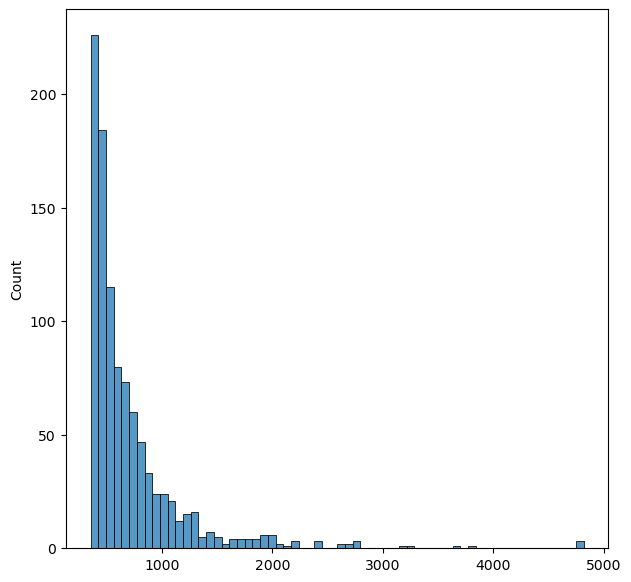

In [ ]:
sns.histplot(number_observations)
print(f'Smallest number of observations: {min(number_observations)}')
print(f'Average Number of Observations: {np.mean(number_observations)}')

231 of unadjusted p-values are <= 0.05


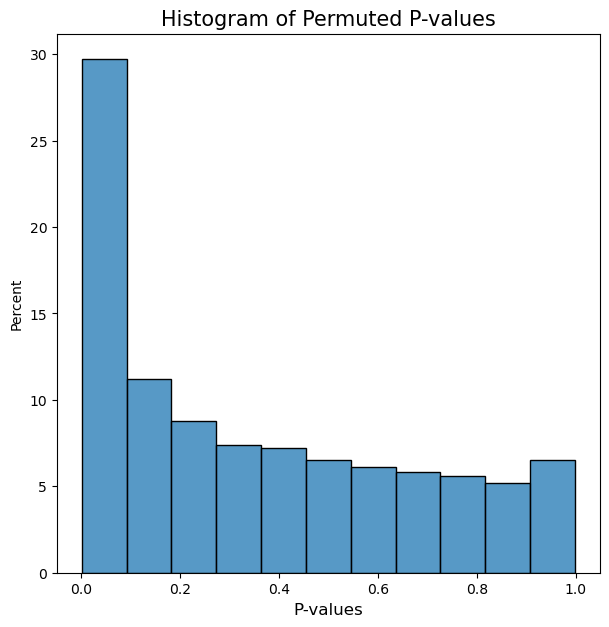

In [ ]:
p = sns.histplot(p_vals, stat='percent')
p.set_xlabel('P-values', fontsize=12)
# p.set_ylabel('Count', fontsize=13)
p.set_title('Histogram of Permuted P-values', fontsize=15)
print(f'{sum(np.array(p_vals) <= 0.05)} of unadjusted p-values are <= 0.05')
# plt.savefig('fig5.png')

Using Bonferroni to control for FWER and Benjamini Hochberg for more power. 

In [ ]:
reject_lst, corrected_pvals, z, k = stat.multitest.multipletests(
    p_vals, alpha=0.05, method='fdr_tsbh', returnsorted=False)
print('Number of rejections using two stage fdr correction (non-negative)', sum(reject_lst))

reject_lst, corrected_pvals, z, k = stat.multitest.multipletests(
    p_vals, alpha=0.05, method='fdr_bh', returnsorted=False)
print('Number of rejections using BH', sum(reject_lst))


Number of rejections using two stage fdr correction (non-negative) 95
Number of rejections using BH 93


In [ ]:
# This code block will track the real correlation values (not the permuted ones) for plotting and analysis.
lst_real_corr = []
for route in tqdm(reg_df.route.unique()):
    # Formatting for OLS
    X = reg_df[reg_df['route'] == route]
    y = reg_df[reg_df['route'] == route]['duration']
    days_since = X['days_since_jan1_2010']
    #OLS model
    X = sm.add_constant(X)
    model = smf.ols(formula = formula, data = X)
    results = model.fit()
    # Collect results
    real_corr = np.corrcoef(results.resid, days_since)[1, 0]
    lst_real_corr.append(real_corr)


100%|██████████| 1000/1000 [00:50<00:00, 19.62it/s]


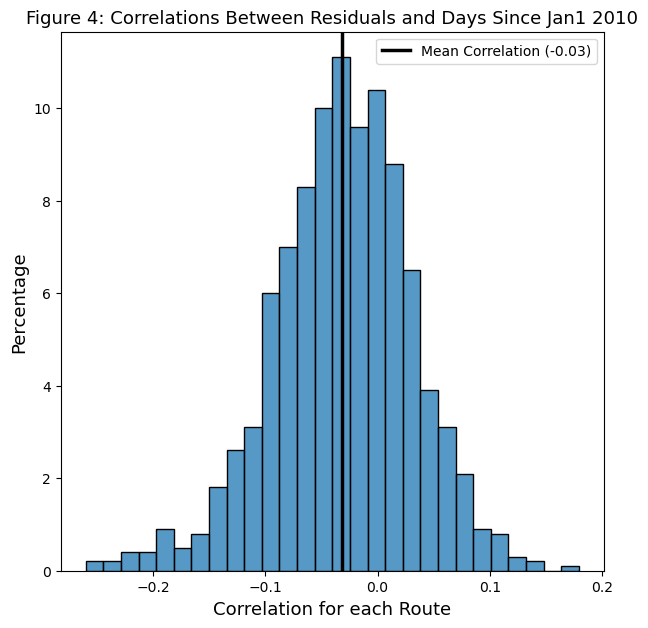

In [ ]:
sns.histplot(lst_real_corr, stat='percent')
plt.xlabel('Correlation for each Route', fontsize=13)
plt.ylabel('Percentage', fontsize=13)
plt.title('Figure 4: Correlations Between Residuals and Days Since Jan1 2010', fontsize=13)
plt.axvline(np.mean(lst_real_corr), color='k', linestyle='-',
            linewidth=2.5, label=f'Mean Correlation ({round(np.mean(lst_real_corr),2)})')
plt.legend()
# plt.savefig('fig4.png')

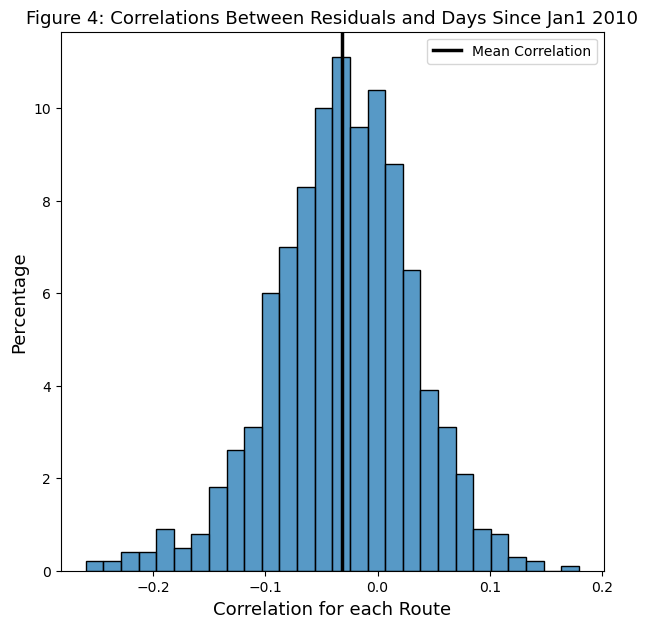

In [ ]:
p = sns.histplot(lst_real_corr, stat='percent')
p.set_xlabel('Correlation for each Route', fontsize=13)
p.set_ylabel('Percentage', fontsize=13)
p.set_title(
    'Figure 4: Correlations Between Residuals and Days Since Jan1 2010', fontsize=13)

plt.axvline(np.mean(lst_real_corr), color='k', linestyle='-',
            linewidth=2.5, label='Mean Correlation')
plt.legend()
np.mean(lst_real_corr)
plt.savefig('fig4.png')

In [ ]:
positive = 0
neg = 0
signif_pvals = np.where(corrected_pvals <= 0.05)[0]
for i in signif_pvals:
    if lst_real_corr[i] >= 0:
        positive += 1
    else:
        neg += 1

print(f'significant positive correlation {positive}')
print(f'significant negative correlation {neg}')
print(f"{100*round(neg/(neg+positive),2)}% of the significant correlations are in the negative direction.")


significant positive correlation 5
significant negative correlation 88
95.0% of the significant correlations are in the negative direction.


In [ ]:
significant_pvals_index = np.random.randint(0,len(signif_pvals), size=6)

### This section focuses on the main 6 routes for interpretation.

In [ ]:
def permut_p_value(resid, days_since, num_perm=25000):
    """ Slightly Changing original function so it can plot residuals.
    """
    permutation_corr = []
    for i in range(num_perm):
        permutation = np.random.permutation(days_since)
        permutation_corr.append(np.corrcoef(results.resid, permutation)[1, 0]) # The [1,0] indexing just grabs one of the correlation values in the matrix.
    permutation_corr = np.array(permutation_corr)
    p_val = sum(np.abs(permutation_corr) > np.abs(
        np.corrcoef(results.resid, days_since)[1, 0]))/num_perm
    return p_val, permutation_corr

In [ ]:
significant_routes = signif_pvals[significant_pvals_index] # Chosen randomly. 
lst_real_corr = []
perm_corr = []
lst_residuals = []
lst_days_since = []
p_values_lst = []
model_results = []

# This loop is a very similar setup to the initial model creation.
for route_index in significant_routes: 
    # Creating individual dataframes for each Route.
    route = reg_df.route.unique()[route_index]
    X = reg_df[reg_df['route'] == route]
    y = reg_df[reg_df['route'] == route]['duration']
    days_since = X['days_since_jan1_2010']

    # Running OLS.
    y = reg_df[reg_df['route'] == route]['duration']
    days_since = X['days_since_jan1_2010']
    X = sm.add_constant(X)
    model = smf.ols(formula = formula, data = X)
    X = sm.add_constant(X)

    # model = sm.OLS(y, X)
    results = model.fit()
    print(results.summary())
    real_corr = np.corrcoef(results.resid, days_since)[1, 0]
    p_val, corr_avg = permut_p_value(results.resid, days_since)

    # Collecting Results.
    lst_residuals.append(results.resid)
    lst_days_since.append(days_since)
    lst_real_corr.append(real_corr)
    p_values_lst.append(p_val)
    perm_corr.append(corr_avg)
    model_results.append(results)

                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     6.799
Date:                Sun, 28 Aug 2022   Prob (F-statistic):           8.01e-10
Time:                        12:02:42   Log-Likelihood:                -3079.7
No. Observations:                 415   AIC:                             6181.
Df Residuals:                     404   BIC:                             6226.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

TypeError: cannot unpack non-iterable numpy.float64 object

In [ ]:
lst_std_resid = []
for result in model_results:
    lst_std_resid.append((result.resid - result.resid.mean()) / result.resid.std())

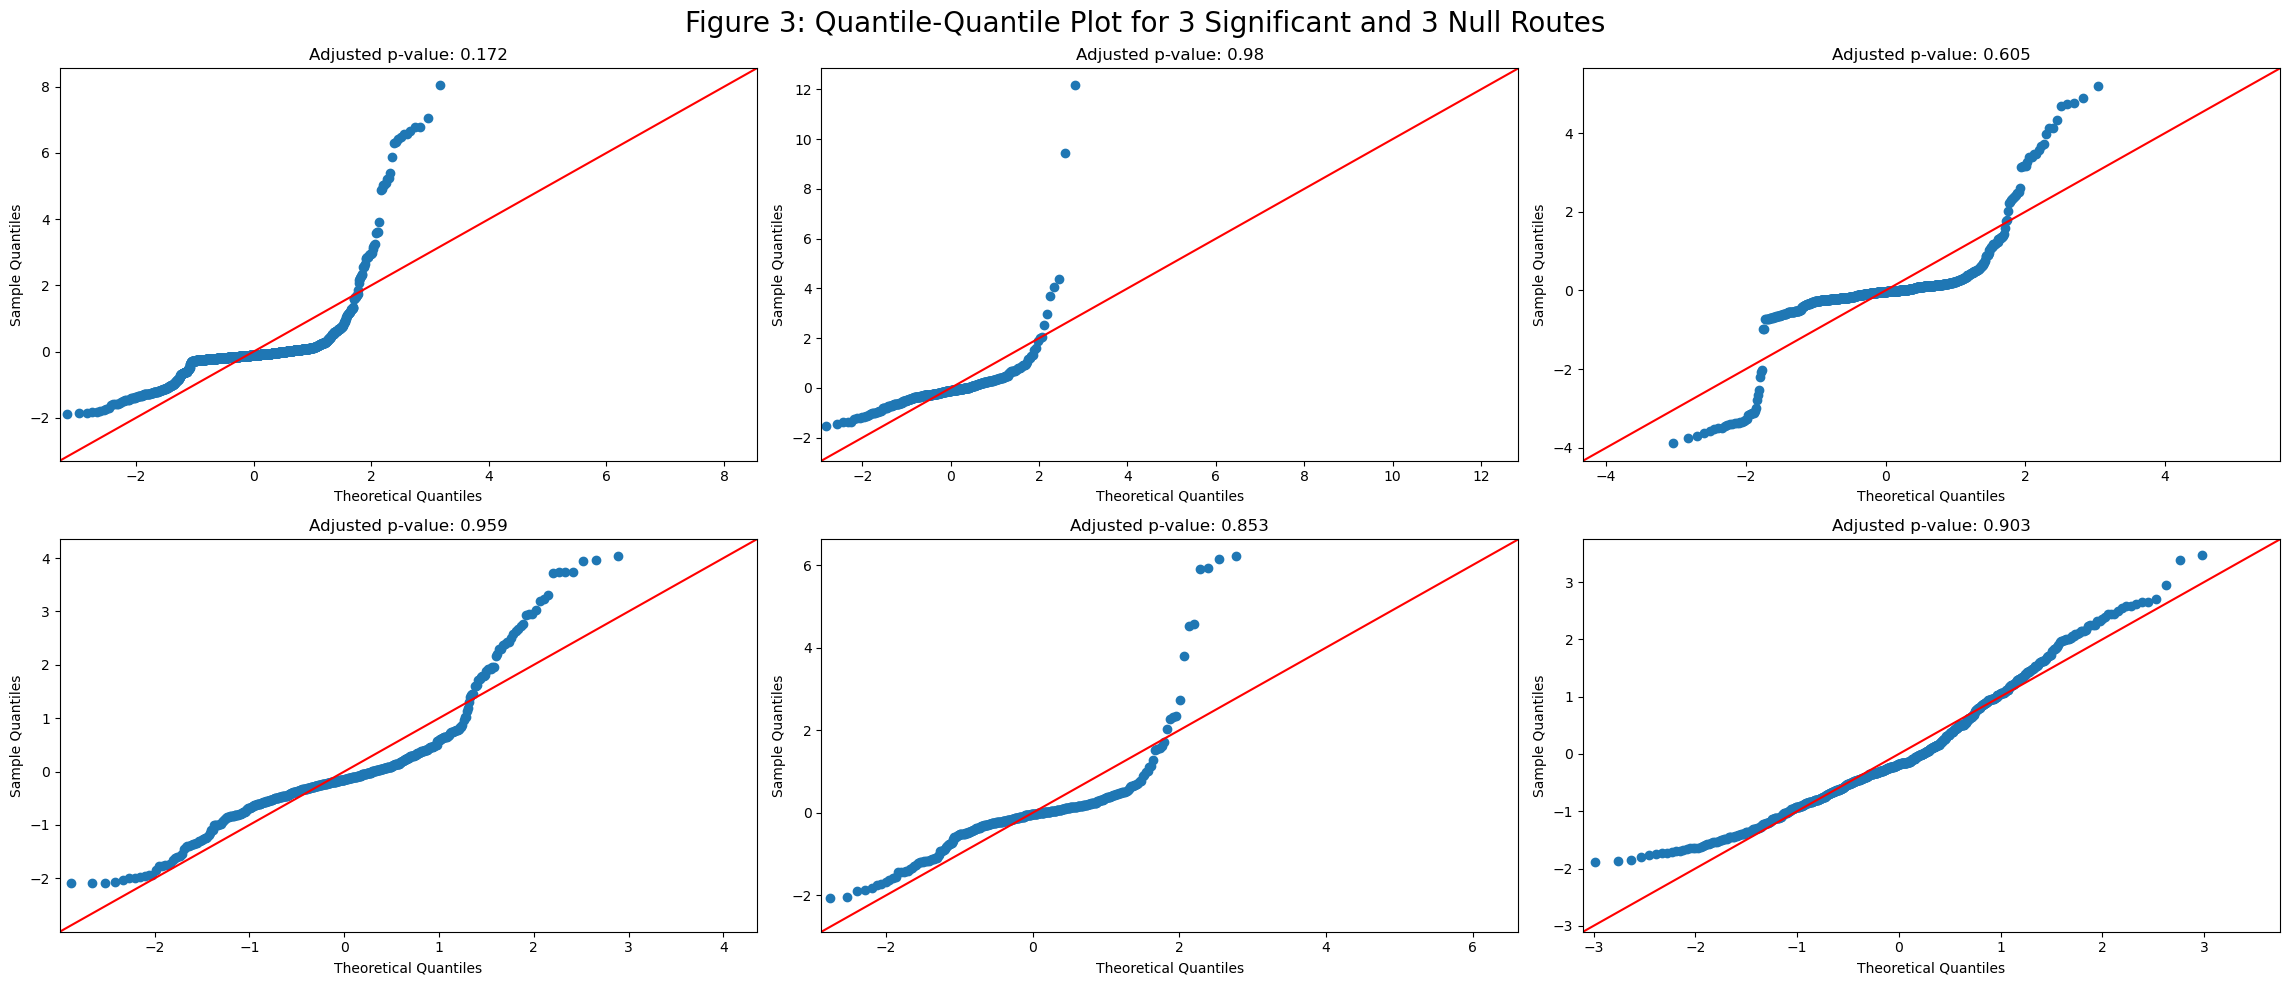

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(23, 10))

p = sm.qqplot(data = lst_std_resid[0], ax = axes[0,0], line="45", )

axes[0, 0].set_title(f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[0]],3)}')

p = sm.qqplot(lst_std_resid[1], ax = axes[0,1], line="45")
axes[0, 1].set_title(f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[1]],3)}')

p = sm.qqplot(lst_std_resid[2], ax = axes[0,2], line="45")
axes[0, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[2]],3)}')

p = sm.qqplot(lst_std_resid[3], ax = axes[1,0], line="45")
axes[1, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[3]],3)}')

p = sm.qqplot(lst_std_resid[4], ax = axes[1,1], line="45")
axes[1, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[4]],3)}')

p = sm.qqplot(lst_std_resid[5], ax = axes[1,2], line="45")
axes[1, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[5]],3)}')
    
plt.suptitle('Figure 3: Quantile-Quantile Plot for 3 Significant and 3 Null Routes', fontsize=20)
plt.tight_layout()
plt.savefig('fig3.png')


In [ ]:
# Gathering residuals after grouping by "days since Jan 10th" for future plotting.

plot_resid = []
plot_days_since = []
for i in range(len(lst_residuals)):
    k = pd.DataFrame({'lst_residuals': lst_residuals[i], 'lst_days_since': lst_days_since[i]}).groupby(
        'lst_days_since')['lst_residuals'].mean()
    plot_days_since.append(k.index)
    plot_resid.append(k.values)


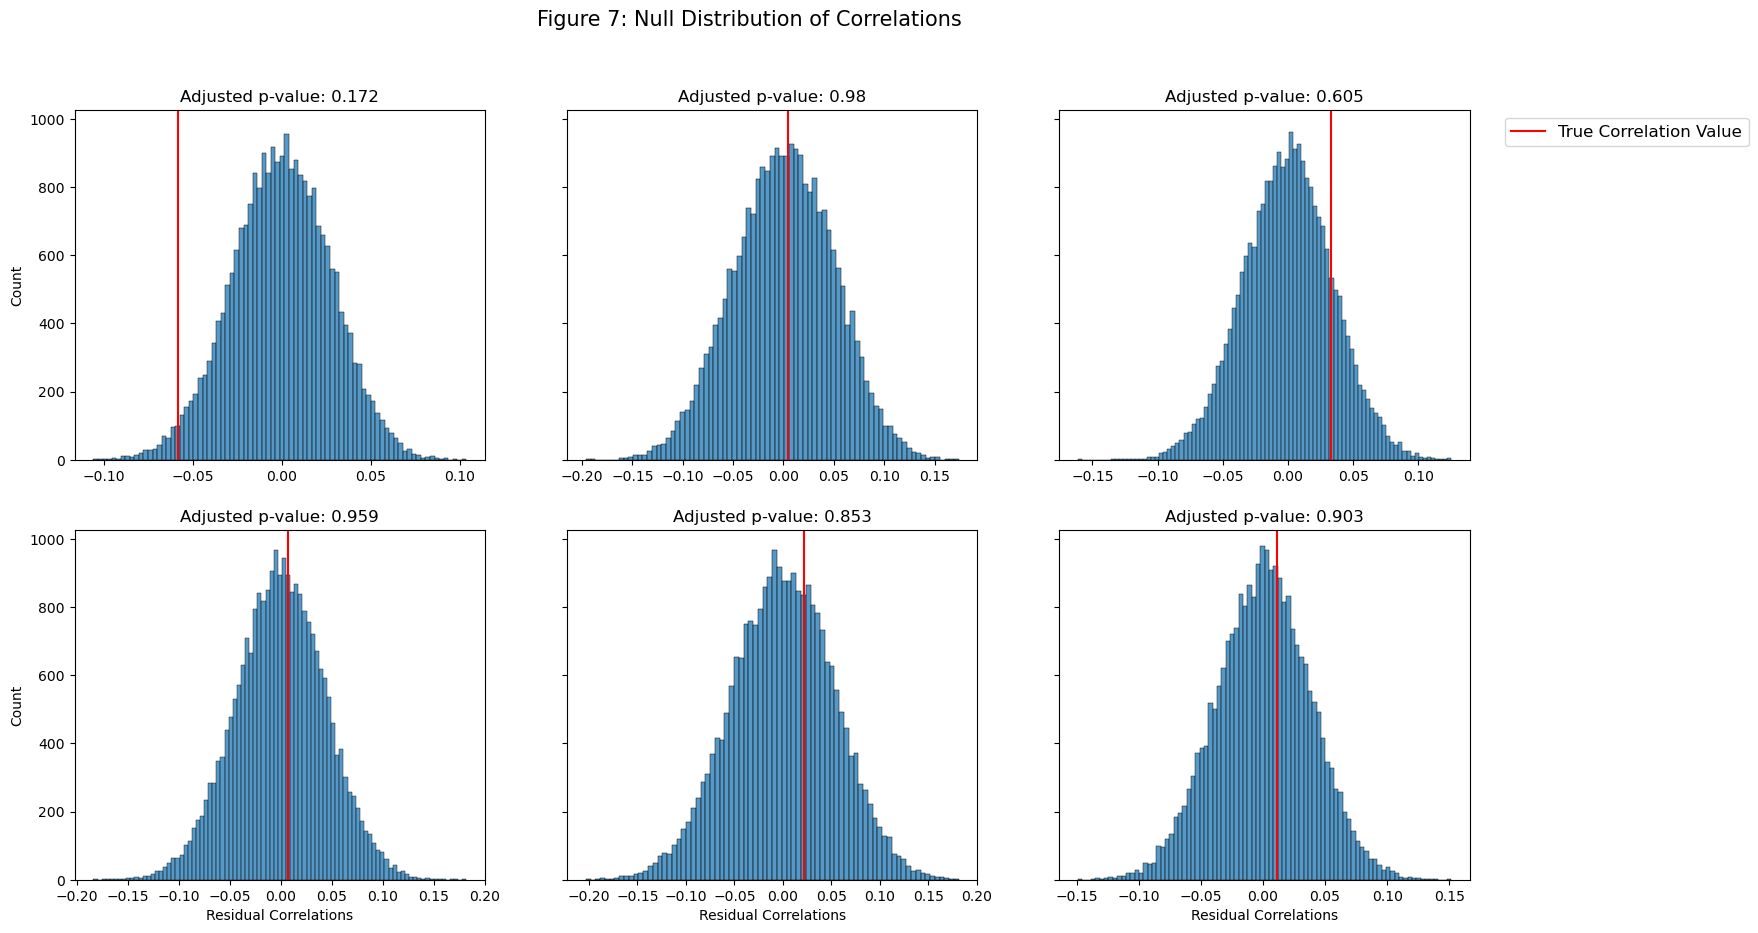

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)

sns.histplot(ax=axes[0, 0], data=perm_corr[0], )
axes[0, 0].axvline(lst_real_corr[0], color='r')
axes[0, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[0]],3)}')

sns.histplot(ax=axes[0, 1], data=perm_corr[1], )
axes[0, 1].axvline(lst_real_corr[1], color='r', label='True Correlation Value')
axes[0, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[1]],3)}')

sns.histplot(ax=axes[0, 2], data=perm_corr[2], )
axes[0, 2].axvline(lst_real_corr[2], color='r', label='True Correlation Value')
axes[0, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[2]],3)}')

sns.histplot(ax=axes[1, 0], data=perm_corr[3], )
axes[1, 0].axvline(lst_real_corr[3], color='r')
axes[1, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[3]],3)}')
axes[1, 0].set_xlabel('Residual Correlations')

sns.histplot(ax=axes[1, 1], data=perm_corr[4], )
axes[1, 1].axvline(lst_real_corr[4], color='r', label='True Correlation Value')
axes[1, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[4]],3)}')
axes[1, 1].set_xlabel('Residual Correlations')

sns.histplot(ax=axes[1, 2], data=perm_corr[5], )
axes[1, 2].axvline(lst_real_corr[5], color='r', label='True Correlation Value')
axes[1, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[5]],3)}')
axes[1, 2].set_xlabel('Residual Correlations')

plt.suptitle('Figure 7: Null Distribution of Correlations', fontsize=15)

axes[0, 2].legend(loc="upper right", bbox_to_anchor=(
    1.7, 1), prop={'size': 12})
plt.savefig('fig7.png')


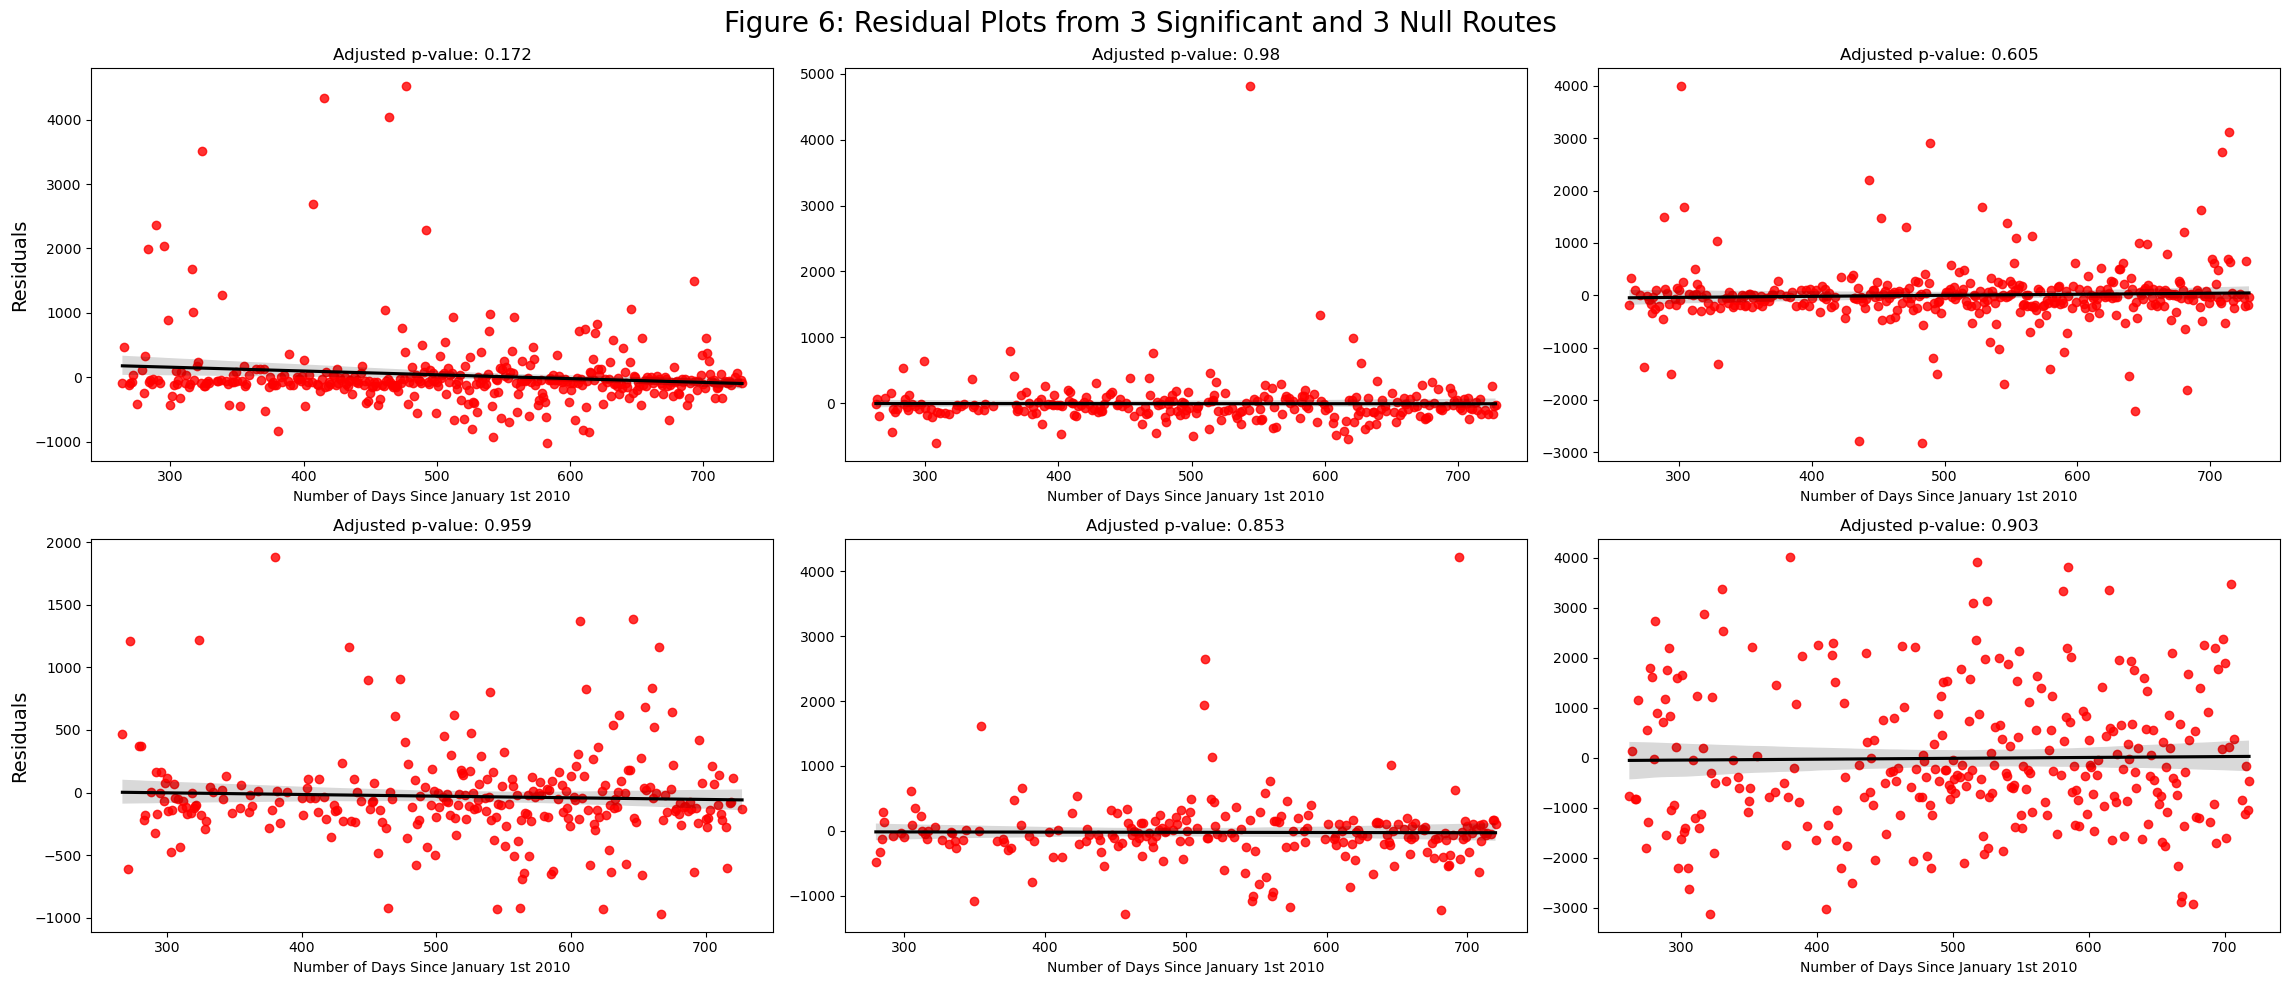

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(23, 10))
p = sns.regplot(ax=axes[0, 0], x=plot_days_since[0], y=plot_resid[0], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
p.set_ylabel('Residuals', fontsize=14)
axes[0, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[0]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')

p = sns.regplot(ax=axes[0, 1], x=plot_days_since[1], y=plot_resid[1], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[0, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[1]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')

p = sns.regplot(ax=axes[0, 2], x=plot_days_since[2], y=plot_resid[2], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[0, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[2]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')


p = sns.regplot(ax=axes[1, 0], x=plot_days_since[3], y=plot_resid[3], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[3]],3)}')
p.set_ylabel('Residuals', fontsize=14)
p.set_xlabel('Number of Days Since January 1st 2010')


p = sns.regplot(ax=axes[1, 1], x=plot_days_since[4], y=plot_resid[4], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[4]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')

p = sns.regplot(ax=axes[1, 2], x=plot_days_since[5], y=plot_resid[5], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[5]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')


plt.suptitle(
    'Figure 6: Residual Plots from 3 Significant and 3 Null Routes ', fontsize=20)
plt.tight_layout()
plt.savefig('fig6.png')


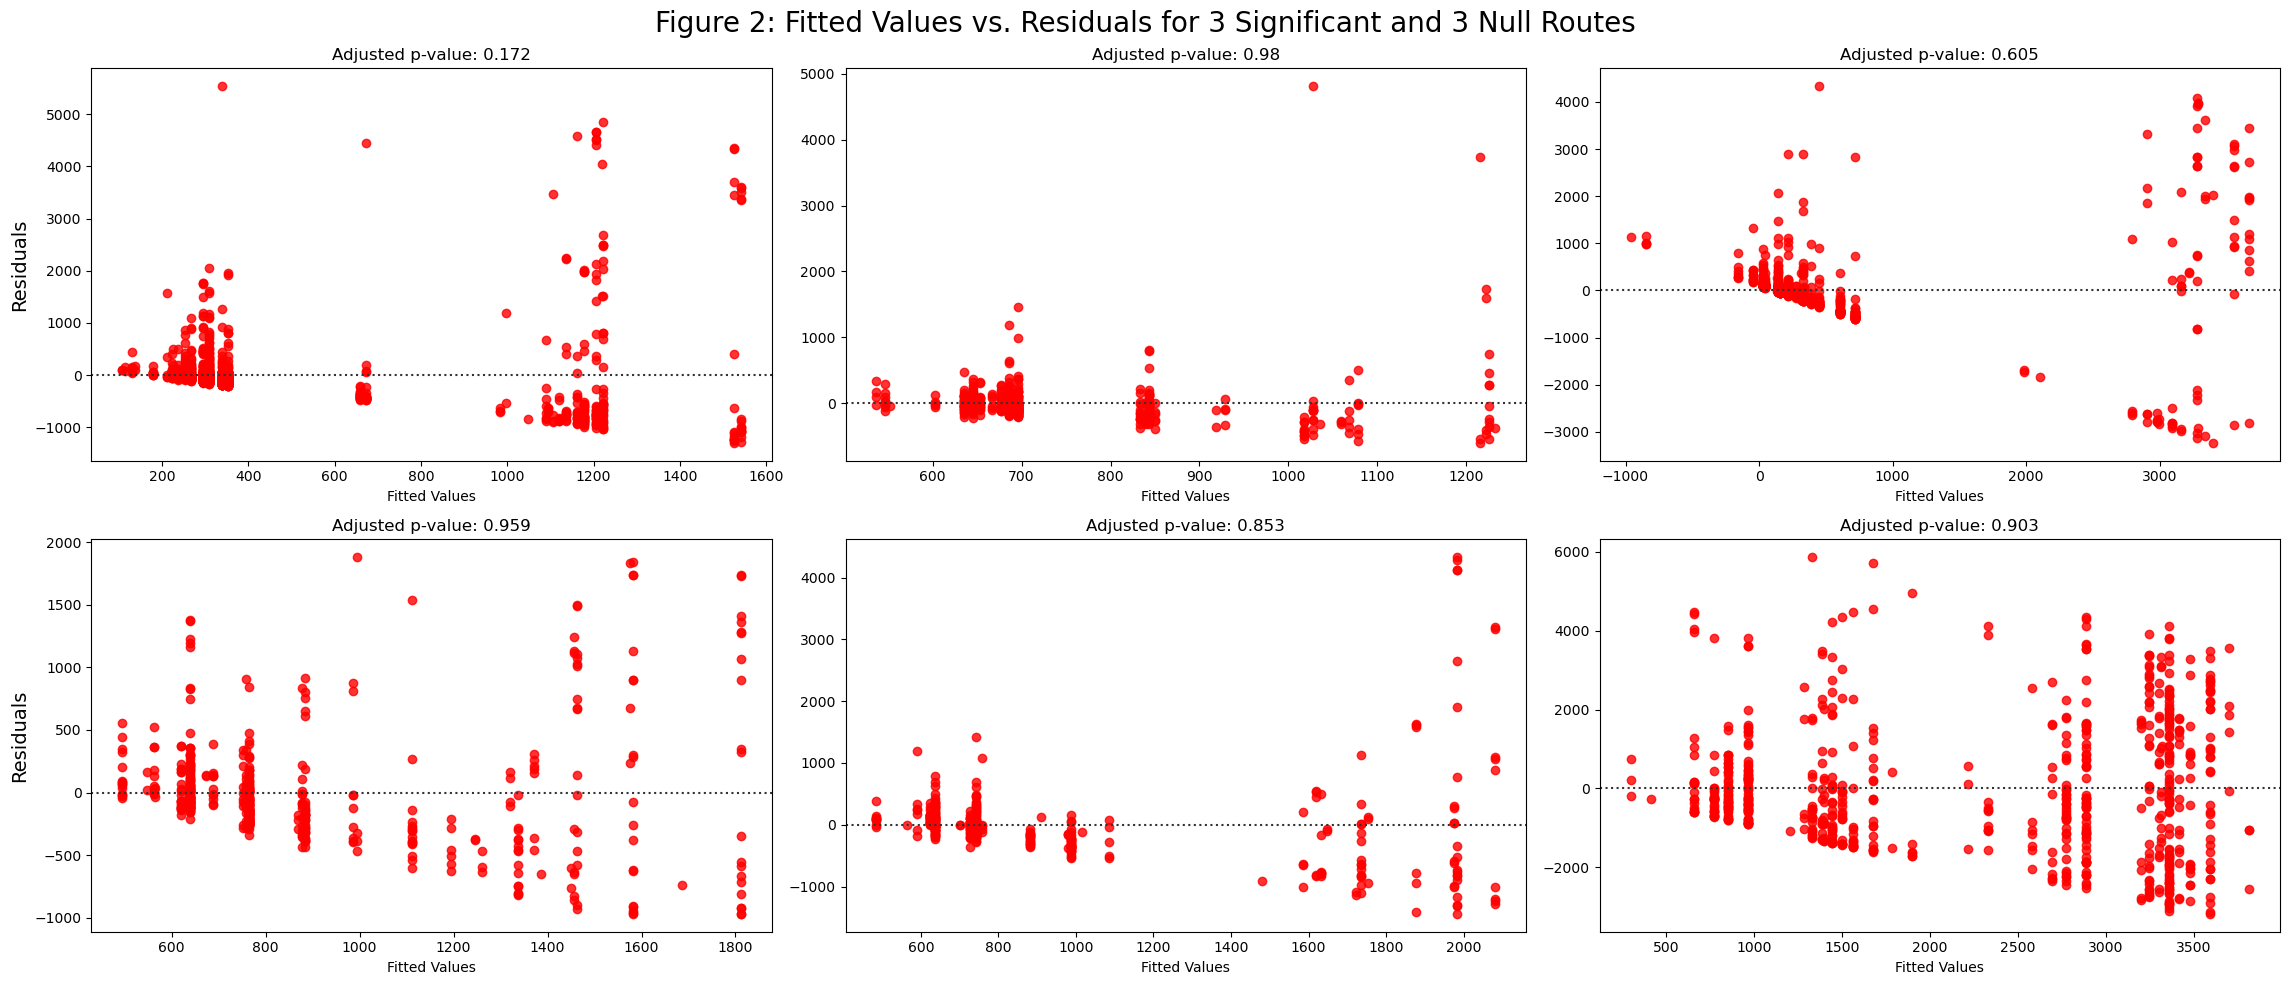

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(23, 10))
p = sns.residplot(ax=axes[0, 0], x=model_results[0].fittedvalues, y=model_results[0].resid, line_kws={
                "color": "black"}, scatter_kws={"color": "red"})

p.set_ylabel('Residuals', fontsize=14)
axes[0, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[0]],3)}')

p.set_xlabel('Fitted Values')


p = sns.residplot(ax=axes[0, 1], x=model_results[1].fittedvalues, y=model_results[1].resid, line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[0, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[1]],3)}')

p.set_xlabel('Fitted Values')

p = sns.residplot(ax=axes[0, 2], x=model_results[2].fittedvalues, y=model_results[2].resid, line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[0, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[2]],3)}')

p.set_xlabel('Fitted Values')


p = sns.residplot(ax=axes[1, 0], x=model_results[3].fittedvalues, y=model_results[3].resid, line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[3]],3)}')
p.set_ylabel('Residuals', fontsize=14)
p.set_xlabel('Fitted Values')


p = sns.residplot(ax=axes[1, 1], x=model_results[4].fittedvalues, y=model_results[4].resid, line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[4]],3)}')
p.set_xlabel('Fitted Values')

p = sns.residplot(ax=axes[1, 2], x=model_results[5].fittedvalues, y=model_results[5].resid, line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[5]],3)}')

p.set_xlabel('Fitted Values')


plt.suptitle('Figure 2: Fitted Values vs. Residuals for 3 Significant and 3 Null Routes', fontsize=20)
plt.tight_layout()

plt.savefig('fig2.png')

In [ ]:
duration = []
days_since = []
significant_routes = [184, 114, 104, 255, 432, 72]
for i in significant_routes:
    route = reg_df.route.unique()[i]
    mask = reg_df[reg_df['route'] == route]
    days_since.append(mask['days_since_jan1_2010'])
    duration.append(mask['duration'])

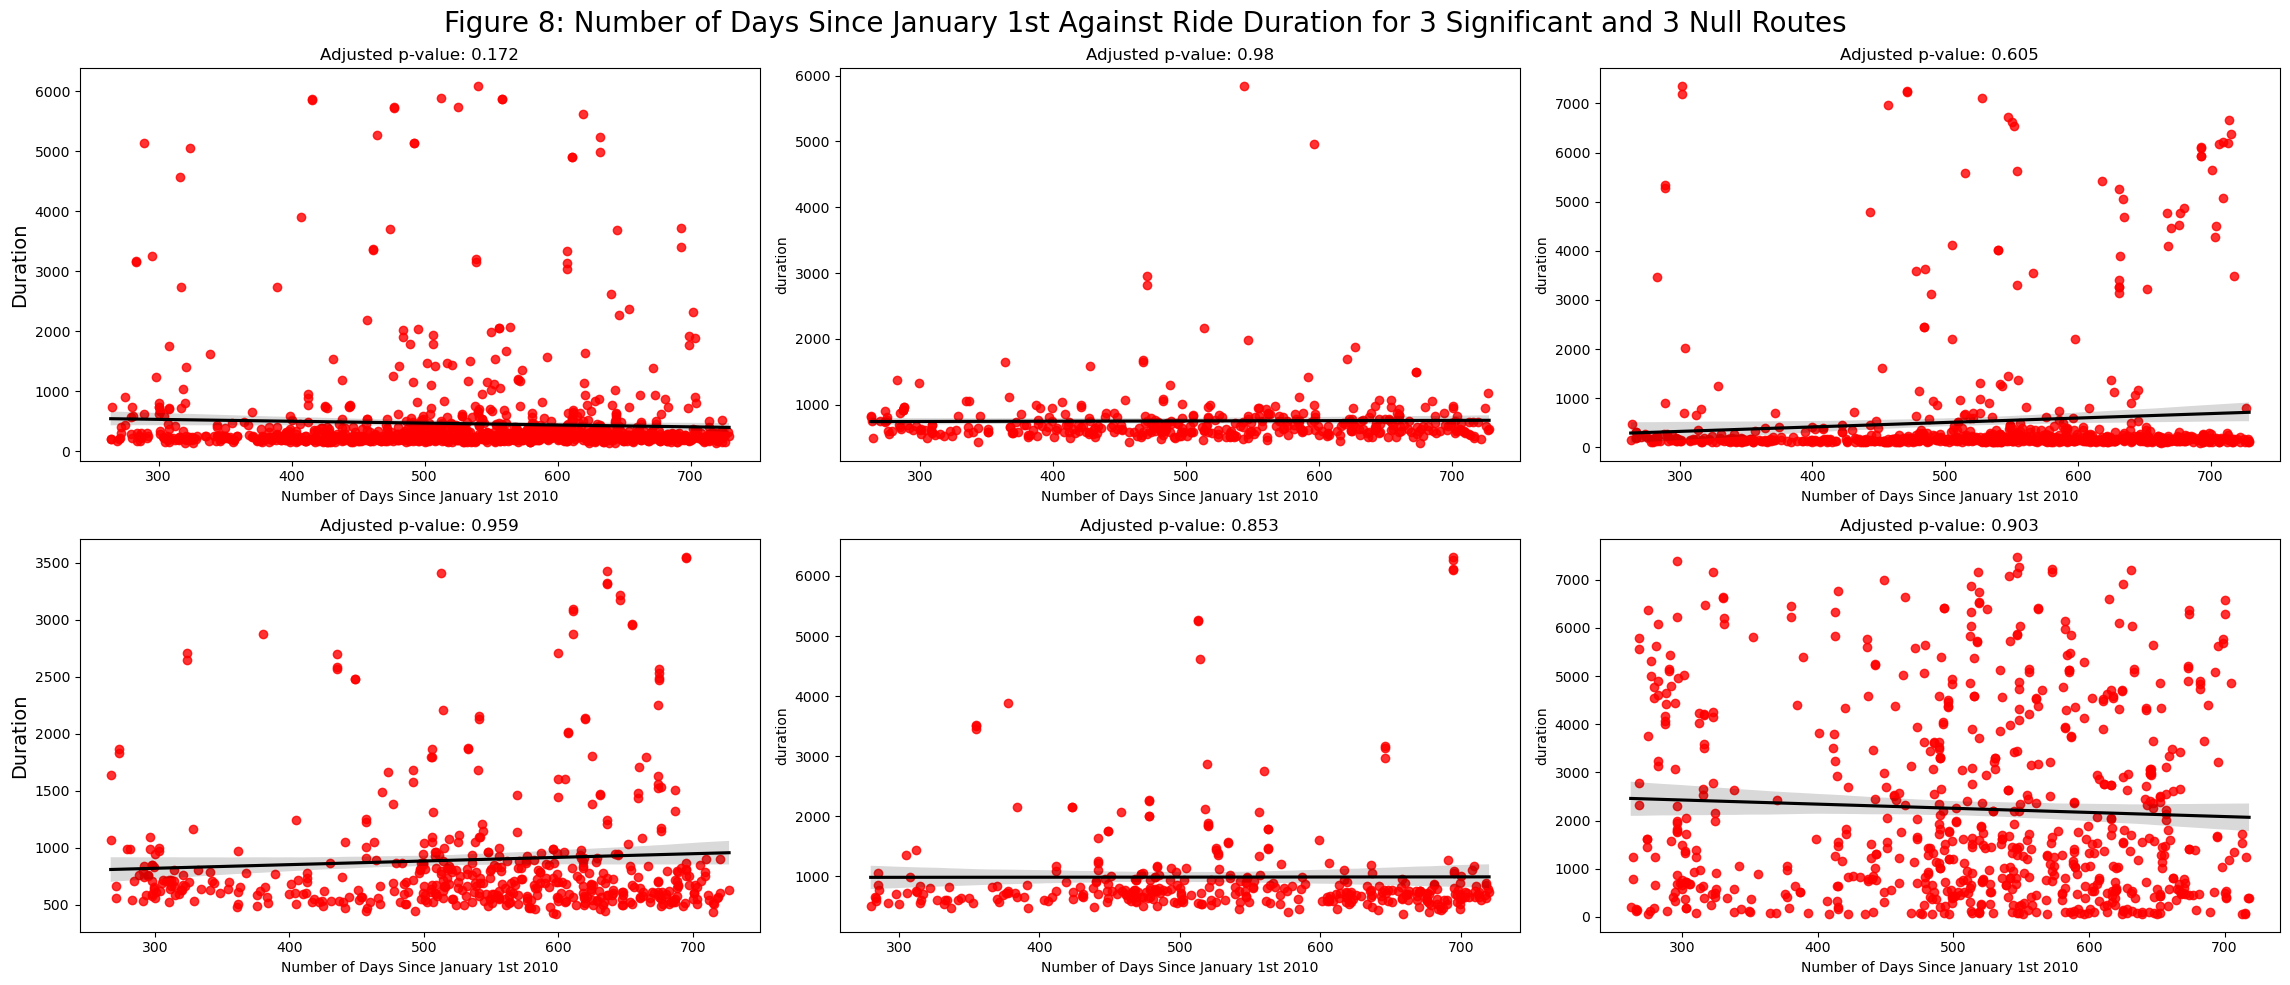

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(23, 10))
p = sns.regplot(ax=axes[0, 0], x=days_since[0], y=duration[0], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
p.set_ylabel('Duration', fontsize=14)
axes[0, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[0]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')


p = sns.regplot(ax=axes[0, 1], x=days_since[1], y=duration[1], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[0, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[1]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')

p = sns.regplot(ax=axes[0, 2], x=days_since[2], y=duration[2], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[0, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[2]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')

p = sns.regplot(ax=axes[1, 0], x=days_since[3], y=duration[3], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[3]],3)}')
p.set_ylabel('Duration', fontsize=14)
p.set_xlabel('Number of Days Since January 1st 2010')

p = sns.regplot(ax=axes[1, 1], x=days_since[4], y=duration[4], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[4]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')

p = sns.regplot(ax=axes[1, 2], x=days_since[5], y=duration[5], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[5]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')


plt.suptitle('Figure 8: Number of Days Since January 1st Against Ride Duration for 3 Significant and 3 Null Routes', fontsize=20)
plt.tight_layout()
# plt.savefig('fig8.png')
